### 🧠 Answer Synthesis from Multiple Sources
✅ What Is It?

Answer synthesis from multiple sources is the process where an AI agent collects information from different retrieval tools or knowledge bases, and merges that information into a single, coherent, and contextually rich answer.

This is a core capability in Agentic RAG, where the system is more than just a simple retriever — it plans, retrieves, and then synthesizes an answer that draws from multiple sources.



🎯 Why It’s Needed?

Most real-world queries are:
- Multifaceted (require multiple types of information)
- Ambiguous or incomplete (need refinement)
- Open-ended (don’t map to a single document or source)

🔍 This makes retrieving from a single vector DB insufficient.

Instead, we want an agent that can:

- Decide what to fetch from where (retrieval planning)
- Retrieve content from multiple tools (e.g., Wikipedia, PDFs, APIs, SQL)
- Evaluate and merge that context
- Produce a single human-like response

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders.youtube import YoutubeLoader
from langchain_community.document_loaders import ArxivLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, END

In [2]:
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o-mini")

In [3]:
def load_text_retriever(file_path):
    docs = TextLoader(file_path, encoding="utf-8").load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = splitter.split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    return vs.as_retriever()

def load_youtube_retriever():
    # Mocked YouTube transcript text
    content = """
    This video explains how agentic AI systems rely on feedback loops, memory, and tool use.
    It compares them to traditional pipeline-based LLMs. Temporal reasoning and autonomous tasking are emphasized.
    """
    doc = Document(page_content=content, metadata={"source": "youtube"})
    vectorstore = FAISS.from_documents([doc], OpenAIEmbeddings())
    return vectorstore.as_retriever()

def wikipedia_search(query: str) -> str:
    print("🌐 Searching Wikipedia...")
    wiki = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
    return wiki.invoke({"query": query})


def arxiv_search(query: str) -> str:
    print("📄 Searching ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content for doc in results[:2]) or "No relevant papers found."

In [4]:
text_retriever = load_text_retriever(r"C:\Coding\AgenticAIWorkspace\assets\sample_docs.txt")
youtube_retriever = load_youtube_retriever()

In [5]:
### state
class MultiSourceRAGState(BaseModel):
    question: str
    text_docs: List[Document] = []
    yt_docs: List[Document] = []
    wiki_context: str = ""
    arxiv_context: str = ""
    final_answer: str = ""

In [6]:
### Retrieval Nodes
def retrieve_text(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = text_retriever.invoke(state.question)
    return state.model_copy(update={"text_docs": docs})

def retrieve_yt(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = youtube_retriever.invoke(state.question)
    return state.model_copy(update={"yt_docs": docs})

def retrieve_wikipedia(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = wikipedia_search(state.question)
    return state.model_copy(update={"wiki_context": result})

def retrieve_arxiv(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = arxiv_search(state.question)
    return state.model_copy(update={"arxiv_context": result})

In [7]:
## synthesize
def synthesize_answer(state: MultiSourceRAGState) -> MultiSourceRAGState:
    
    context = ""

    context += "\n\n[Internal Docs]\n" + "\n".join([doc.page_content for doc in state.text_docs])
    context += "\n\n[YouTube Transcript]\n" + "\n".join([doc.page_content for doc in state.yt_docs])
    context += "\n\n[Wikipedia]\n" + state.wiki_context
    context += "\n\n[ArXiv]\n" + state.arxiv_context

    prompt = f"""You have retrieved relevant context from multiple sources. Now synthesize a complete and coherent answer.

Question: {state.question}

Context:
{context}

Final Answer:"""

    answer = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"final_answer": answer})

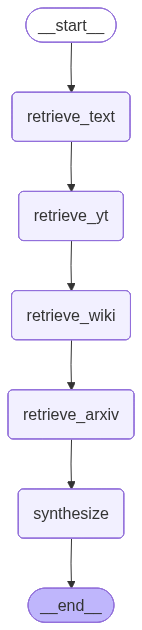

In [8]:
builder = StateGraph(MultiSourceRAGState)

builder.add_node("retrieve_text", retrieve_text)
builder.add_node("retrieve_yt", retrieve_yt)
builder.add_node("retrieve_wiki", retrieve_wikipedia)
builder.add_node("retrieve_arxiv", retrieve_arxiv)
builder.add_node("synthesize", synthesize_answer)

builder.set_entry_point("retrieve_text")
builder.add_edge("retrieve_text", "retrieve_yt")
builder.add_edge("retrieve_yt", "retrieve_wiki")
builder.add_edge("retrieve_wiki", "retrieve_arxiv")
builder.add_edge("retrieve_arxiv", "synthesize")
builder.add_edge("synthesize", END)

graph = builder.compile()
graph

In [9]:
question = "What are transformer agents and how are they evolving in recent research?"
state = MultiSourceRAGState(question=question)
result = graph.invoke(state)

print("✅ Final Answer:\n")
print(result["final_answer"])


🌐 Searching Wikipedia...
📄 Searching ArXiv...
✅ Final Answer:

**Transformer Agents: Evolution and Recent Research Developments**

**What Are Transformer Agents?**

Transformer agents are complex AI systems that utilize the Transformer architecture—initially designed for natural language processing—to facilitate autonomous decision-making and interaction within an environment. These agents encapsulate the foundational principles behind large language models (LLMs) like GPT (Generative Pre-trained Transformers), which can generate, interpret, and respond to human language and other types of data. The capabilities of transformer agents extend beyond basic text generation; they can engage in tasks requiring memory retention, planning, and interaction with various tools and environments. 

At their core, transformer agents operate via an agent loop comprising three primary activities:
1. **Thinking**: The agent processes input data to understand the current state of the environment and its

In [10]:
result

{'question': 'What are transformer agents and how are they evolving in recent research?',
 'text_docs': [Document(id='7db90012-e23f-4c38-bb4d-d61ad95d058a', metadata={'source': 'C:\\Coding\\AgenticAIWorkspace\\assets\\sample_docs.txt'}, page_content='An agent loop is the cycle of thinking, acting, and observing. It allows an AI agent to continuously refine its actions based on results.\nThis feedback loop is crucial in autonomous systems to adapt in real-time.\nAgent-based architectures benefit from memory, planning, and interaction with tools.')],
 'yt_docs': [Document(id='43cc2086-8b02-432c-8561-3abc7e28cc18', metadata={'source': 'youtube'}, page_content='\n    This video explains how agentic AI systems rely on feedback loops, memory, and tool use.\n    It compares them to traditional pipeline-based LLMs. Temporal reasoning and autonomous tasking are emphasized.\n    ')],
 'wiki_context': 'Page: Generative pre-trained transformer\nSummary: A generative pre-trained transformer (GPT) i